In [1]:
using AtomsIO
using JSON3
using Statistics
using CairoMakie
using Unitful, UnitfulAtomic
using Distributions
bohr2angstrom(x) = ustrip(uconvert(u"angstrom", x * u"bohr"))

# these are relative to 1 CSS px
inch = 96
pt = 4/3
cm = inch / 2.54
default_width = 9 * cm  # Column width

340.1574803149606

In [2]:
file = "Si_diamond.extxyz"
system = load_system(file)
a0_exp = system[:a0_exp]

# Load results
kgrid = 14
prefix = "$(file)_kgrid$(kgrid)_relax_scfres0.jld2"
results_linear_pushforward = JSON3.read("$(prefix)_linear_pushforward.json")

JSON3.Object{Vector{UInt8}, Vector{UInt64}} with 3 entries:
  :lattice_constant_grad        => [-2.14561, 0.281068, 0.0803419]
  :lattice_constant             => 10.3282
  :lattice_constant_uncertainty => 0.228922

In [3]:
results_ensemble = JSON3.read("$(prefix)_ensemble.json")

JSON3.Object{Vector{UInt8}, Vector{UInt64}} with 3 entries:
  :ensemble      => {…
  :theta_ens     => Array[[1.01343, 1.09255, 0.37127], [0.909042, 0.0829383, 2.…
  :ensemble_nscf => {…

In [4]:
a0_bf = bohr2angstrom(results_linear_pushforward["lattice_constant"])
σ_linear_pushforward = bohr2angstrom(results_linear_pushforward["lattice_constant_uncertainty"])
@show σ_linear_pushforward
normal_linear_pushforward = Normal(a0_bf, σ_linear_pushforward)

a0_ens = bohr2angstrom.(results_ensemble["ensemble"]["lattice_constants"])
a0_ens_nscf = bohr2angstrom.(results_ensemble["ensemble_nscf"]["lattice_constants"])

@show σ_ens      = sqrt(mean(abs2, a0_ens      .- a0_bf))
@show σ_ens_nscf = sqrt(mean(abs2, a0_ens_nscf .- a0_bf))

σ_linear_pushforward = 0.12114019129426822
σ_ens = sqrt(mean(abs2, a0_ens .- a0_bf)) = 0.10016340901672088
σ_ens_nscf = sqrt(mean(abs2, a0_ens_nscf .- a0_bf)) = 0.09422457021391623


0.09422457021391623

In [5]:
hcat(a0_ens, a0_ens_nscf)

10×2 Matrix{Float64}:
 5.51451  5.5214
 5.56536  5.56516
 5.45076  5.45108
 5.70743  5.69454
 5.29961  5.31594
 5.4672   5.47095
 5.42971  5.45029
 5.48332  5.48338
 5.46568  5.46595
 5.47302  5.47425

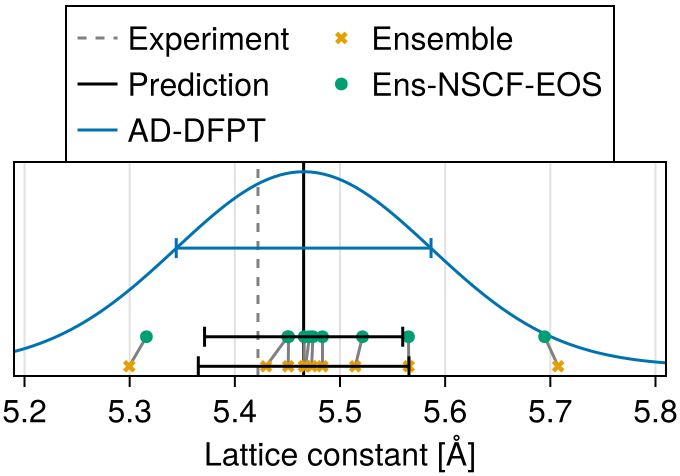

In [14]:
fig = Figure(size=(default_width, 0.7 * default_width), fontsize=12pt, figure_padding=(5pt, 5pt, 2pt, 2pt))
colors = Makie.wong_colors()

ax = Makie.Axis(fig[1,1], xlabel="Lattice constant [Å]")
xlims!(ax, 5.19, 5.81)
hideydecorations!(ax)

# vlines!([a0_exp], color=:gray, linestyle=:dash)
# vlines!([a0_bf], color=:black)
vlines!([a0_exp], label="Experiment", color=:gray, linestyle=:dash)
vlines!([a0_bf], label="Prediction", color=:black)

# Draw connections between ensemble and NSCF-ensemble samples
for i in 1:10
    lines!([a0_ens[i], a0_ens_nscf[i]], [0, 0.5], color=:gray)
end

# Linearized pushforward Gaussian    
x = range(4, 7, length=500)
lines!(x, pdf.(normal_linear_pushforward, x), label="AD-DFPT", color=colors[1])
errorbars!(ax, [a0_bf], [2], [σ_linear_pushforward], direction=:x, whiskerwidth = 10, color=colors[1])

scatter!(ax, a0_ens, zeros(length(a0_ens)), marker=:x, label="Ensemble", color=colors[2])
errorbars!(ax, [a0_bf], [0], [σ_ens], direction=:x, whiskerwidth = 10, color=:black)

scatter!(ax, a0_ens_nscf, 0.5ones(length(a0_ens_nscf)), label="Ens-NSCF-EOS", color=colors[3])
errorbars!(ax, [a0_bf], [0.5], [σ_ens_nscf], direction=:x, whiskerwidth = 10, color=:black)

# axislegend(ax)
Legend(fig[1,1,Top()], ax, orientation=:horizontal, nbanks=3)
# Legend(fig[0,1], ax, orientation=:horizontal)

save(joinpath(@__DIR__, "Si_lattice_const_uncertainty_beef.pdf"), fig)
fig